## Background

As part of my undergraduate studies I recently had to write a formal report on the exciting
topic of mechanical resonance after having collected data from the transient and
steady state responses of a oscillating torsional pendulum.

Rather problematically, we have yet to be taught any meaningful data processing outside of basic Excel regression,
which proved a bit of a hindrance in establishing the quality factor of the oscillator.

![Figure 1](./graph1.png 
"Figure 1: Graph of amplitude and angular frequency")

Supposedly this could be done by taking the ratio of the amplitude at resonance and the amplitude
for an angular frequency of 0 radians per second. The amplitude at resonance would then have to be
guestimated from the graph in Figure 1.
That’s hardly very scientific and in my case introduced such large errors that
the estimated quality factor was effectively useless with an uncertainty north of 20%.

## A better way
A better way of going about this would be to establish the resonant frequency $ω_0$
and the damping coefficient $γ$ by fitting the data to the following model:

$$
X(ω) = \frac{f}{\sqrt{\qty(ω^2_0 - ω^2)^2} + 4γ^2 ω^2}
$$
<p class="caption">Equation 1: Amplitude as a function of angular frequency</p>

The quality factor could then be found without resorting to questionable approximations by using the definition of the quality factor:

$$
Q = \frac{ω_0}{2γ}
$$
<figcaption>Equation 2: Definition of quality factor</figcaption>

Performing a custom regression analysis is however not a trivial task given the set of tools made available to a first year Natural Sciences student in the UK.

## Python to the rescue
Luckily Python is an excellent language for all things science and a range of packages give easy access to powerful data analysis tools.

In order to perform the custom fit I used the following Python packages:

- lmfit
- numpy
- pandas
- sympy
- matplotlib
- uncertainties

### Getting the Excel data into pandas

The first challenge is to get the data from the [Excel file](./E5data.xlsx) into a `pandas.DataFrame`. This is code rather crudely by using the `pandas.read_excel` function and simply selecting the data for the two different degrees of damping examined.


In [25]:
# Initialisation
import numpy as np
from lmfit import Model
import pandas as pd
import sympy as sym
from matplotlib import pyplot as plt
from uncertainties import ufloat

XLSX_LOC = 'E5data.xlsx'
XLSX_SHEET_NAME = 'E5-forced'

In [26]:
raw_df = pd.read_excel(XLSX_LOC, sheet_name=XLSX_SHEET_NAME)

df = pd.DataFrame(columns=['X', 'omega', 'I_braking'])

# Get 0.3A data
df1_raw = raw_df.iloc[7:22]
df1 = pd.DataFrame()
df1['X'] = df1_raw['Unnamed: 6'].astype(np.float64)
df1['omega'] = df1_raw['Unnamed: 3'].astype(np.float64)
df1['I_braking'] = 0.3

# Get 0.6A data
df2_raw = raw_df.iloc[26:34]
df2 = pd.DataFrame()
df2['X'] = df2_raw['Unnamed: 6'].astype(np.float64)
df2['omega'] = df2_raw['Unnamed: 3'].astype(np.float64)
df2['I_braking'] = 0.6

# Reindex
df = pd.concat([df, df1, df2])
df = df.reset_index(drop=True).reset_index().set_index(['I_braking'])
df.head()

,index,X,omega
I_braking,,,
0.3,0,0.45,5.317223
0.3,1,0.85,4.472018
0.3,2,2.90,3.690564
0.3,3,4.00,3.580163
0.3,4,4.50,3.544815


<figcaption>Figure 2: Raw data</figcaption>

Which outputs the DataFrame as shown in Figure 2.

### Defining a function to fit to

Now we need to use lmfit to define a Model to which we can fit the data. This is done by defining a function corresponding to Equation 2.

If we try to fit the function to the data straight away we run into problems — we need to provide a reasonable initial guess of the different parameters. This could probably be done by simple intelligent guess-work, but we could also solve 3 equations with 3 unknowns using the `sympy` package and by defining meaningful bounds for our parameters.

In [31]:
# Setup lmfit model
def fit_func(omega_, f_, omega0_, gamma_):
    return f_ / (
        np.sqrt((omega0_**2 - omega_**2) ** 2 + 4 * (gamma_**2) * (omega_**2))
    )


model = Model(fit_func)

# Setup SymPy
omega, f, omega0, gamma, X = sym.symbols("omega,f,omega0,gamma,X")
eq = sym.Eq(
    f / (sym.sqrt((omega0**2 - omega**2) ** 2 + 4 * (gamma**2) * (omega**2))), X
)




### Performing the fit

We are now ready to perform the fit. We need to do it twice — once for each degree of damping ($I_{braking} = 0.3A$ and $I_{braking} = 0.6A$). We store the results of our regression analysis in the a `dict` called `results`


In [28]:
results = {}
for damp_deg in [0.3, 0.6]:
    # Set up SymPy equations

    eqs = []
    for i in [0, 2, 4]:
        eqs.append(
            eq.subs(
                [
                    (X, df.loc[damp_deg]["X"].iloc[i]),
                    (omega, df.loc[damp_deg]["omega"].iloc[i]),
                ]
            )
        )

    sol = sym.nsolve(eqs, (omega0, gamma, f), (3, 1, 10), dict=True, verify=False)

    params = model.make_params(
        omega0_=np.float64(sol[0][omega0]),
        f_=np.float64(sol[0][f]),
        gamma_=np.float64(sol[0][gamma]),
    )
    params["omega0_"].min = 2
    params["omega0_"].max = 5
    params["f_"].min = 0
    params["gamma_"].min = 0

    result = model.fit(
        df.loc[damp_deg]["X"], params, omega_=df.loc[damp_deg]["omega"], method="Nelder"
    )

    results[damp_deg] = result



### Plotting the data and fit

Finally we are ready to plot the data and accompanying fits using `matplotlib`. This is fairly straight forward for anyone used to `matplotlib` or `MATLAB`. By using lmfit we get easy access to the standard errors, which we can find by doing `ModelResult.eval_uncertainty()`. We can also calculate the $R²$ value from the residuals from the fit.

`ufloat` from the `uncertainties` package is used to easily propagate the standard errors from the $ω₀$ and $γ$ estimates onto the quality factor estimate (see Equation 2).

### The result

`matplotlib` gives us this lovely figure as a reward for our hard work.

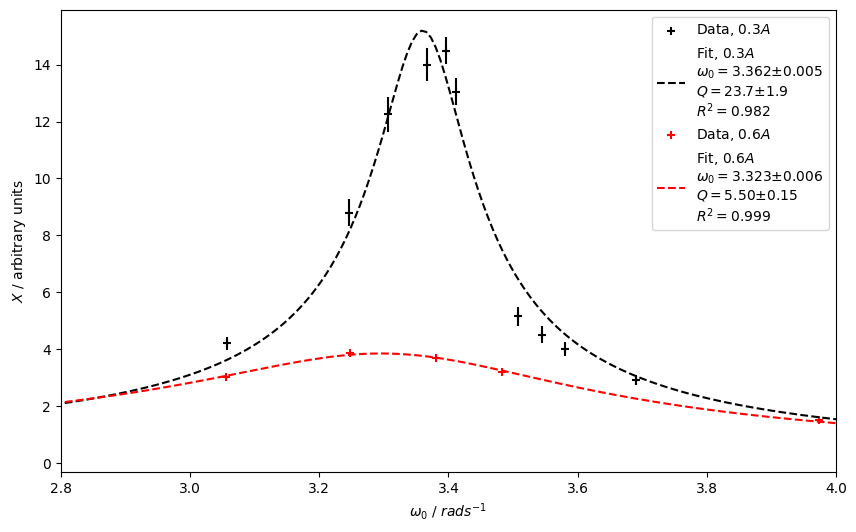

In [29]:
colors = {0.3: "k", 0.6: "r"}

NUM_FIT_POINTS = 500

fig, ax = plt.subplots(figsize=(10, 6))
for deg_damp, result in results.items():
    x_vals = df.loc[deg_damp]["omega"]
    y_vals = df.loc[deg_damp]["X"]
    x_vals_dense = np.linspace(min(x_vals), max(x_vals), NUM_FIT_POINTS)

    r_squared = 1 - result.residual.var() / np.var(y_vals)

    uomega0 = ufloat(result.params["omega0_"].value, result.params["omega0_"].stderr)
    ugamma = ufloat(result.params["gamma_"].value, result.params["gamma_"].stderr)
    q_factor = uomega0 / (2 * ugamma)

    plt.scatter(
        x_vals, y_vals, None, colors[deg_damp], "+", label=f"Data, ${deg_damp}A$"
    )
    plt.errorbar(
        x_vals,
        y_vals,
        xerr=None,
        yerr=list(result.eval_uncertainty()),
        ecolor=colors[deg_damp],
        fmt="none",
    )
    label = (
        f"Fit, ${deg_damp}A$\n"
        f"$ω_0={uomega0:P}$\n"
        f"$Q={q_factor:P}$\n"
        f"$R^2={r_squared:.3f}$"
    )
    plt.plot(
        x_vals_dense,
        result.model.eval(result.params, omega_=x_vals_dense),
        colors[deg_damp] + "--",
        label=label,
    )

ax.set_xlim(2.8, 4.0)
ax.set_ylabel("$X$ / arbitrary units")
ax.set_xlabel("$ω_0$ / $rad s^{-1}$")
plt.legend()


<figcaption>Figure 3: Data with fit</figcaption>

## Conclusion

Using the method suggested by the Lab Manual I got a quality factor value of $Q = 5.6$ with standard error of $σ = 1.2$. By fitting the data to the theoretical model we instead get a value of $Q = 5.57$ with a standard error of $σ=0.15$, from which actual conclusions can be drawn.

I am assured University of Cambridge will join the 21st century any day now, but until then we will continue to perform non-linear best-fits by hand and creative imagination.

The Jupyter notebook containing the code can be found on my GitHub along with the raw Excel file: [GitHub/JeppeKlitgaard](https://github.com/JeppeKlitgaard/E5-mechanical-resonance).